In [16]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential, load_model # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training
import seaborn as sns
from sklearn import preprocessing
import calendar
from sklearn.model_selection import TimeSeriesSplit

In [20]:
data = pd.read_csv("/content/drive/MyDrive/temp/train.csv")

In [3]:
data.head()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,NTM3,X1,A28,WHOLESALE,Large,Powder,May-21,10.16
1,NTM2,X1,A9,DIRECT,Large,Powder,Oct-20,134.28
2,NTM3,X2,A20,DIRECT,Large,Powder,Dec-20,12.46
3,NTM3,X1,A18,WHOLESALE,Small,Powder,Feb-21,107.22
4,NTM2,X1,A28,DIRECT,Large,Liquid,Nov-20,197.76


In [21]:
# check columns with data type object
col_list = [c for c in data.columns if data[c].dtype == 'object' and c != 'timestamp']
print(col_list)

['ProductType', 'Manufacturer', 'Area Code', 'Sourcing Channel', 'Product Size', 'Product Type', 'Month of Sourcing']


In [22]:
#Checking null are available in dataframe columns
data.isnull().sum()
data.groupby(by=['Month of Sourcing']).count()

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Sourcing Cost
Month of Sourcing,,,,,,,
Apr-21,52438,52438,52438,52438,52438,52438,52438
Aug-20,40640,40640,40640,40640,40640,40640,40640
Dec-20,52752,52752,52752,52752,52752,52752,52752
Feb-21,50562,50562,50562,50562,50562,50562,50562
Jan-21,50844,50844,50844,50844,50844,50844,50844
Jul-20,42469,42469,42469,42469,42469,42469,42469
Mar-21,56643,56643,56643,56643,56643,56643,56643
May-21,53172,53172,53172,53172,53172,53172,53172
Nov-20,60446,60446,60446,60446,60446,60446,60446


In [23]:
#pre-processing the data.
le = preprocessing.LabelEncoder()
data['ProductType']  = le.fit_transform(data['ProductType'])
data['Manufacturer']  = le.fit_transform(data['Manufacturer'])
data['Area Code']  = le.fit_transform(data['Area Code'])
data['Sourcing Channel']  = le.fit_transform(data['Sourcing Channel'])
data['Product Size']  = le.fit_transform(data['Product Size'])
data['Product Type']  = le.fit_transform(data['Product Type'])

In [24]:
data['Month of Sourcing'] = pd.to_datetime([f'20{y}-{m}-01' for y, m in zip(data['Month of Sourcing'].str.split('-').str[1], data['Month of Sourcing'].str.split('-').str[0])])

In [25]:
data = data.sort_values(by='Month of Sourcing', ascending=False)
data

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost
0,2,0,19,3,1,1,2021-05-01,10.16
410215,2,0,16,0,2,1,2021-05-01,64.46
227368,1,0,2,0,1,0,2021-05-01,151.70
136731,0,0,44,0,1,1,2021-05-01,146.98
227357,2,0,16,0,2,1,2021-05-01,73.15
...,...,...,...,...,...,...,...,...
420994,0,1,36,0,2,1,2020-07-01,157.09
67975,0,1,37,0,1,0,2020-07-01,0.00
420992,0,0,21,0,2,1,2020-07-01,136.92
210469,0,1,13,0,2,1,2020-07-01,71.85


In [26]:
data = data.set_index('Month of Sourcing')

In [27]:
data

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Sourcing Cost
Month of Sourcing,,,,,,,
2021-05-01,2,0,19,3,1,1,10.16
2021-05-01,2,0,16,0,2,1,64.46
2021-05-01,1,0,2,0,1,0,151.70
2021-05-01,0,0,44,0,1,1,146.98
2021-05-01,2,0,16,0,2,1,73.15
...,...,...,...,...,...,...,...
2020-07-01,0,1,36,0,2,1,157.09
2020-07-01,0,1,37,0,1,0,0.00
2020-07-01,0,0,21,0,2,1,136.92


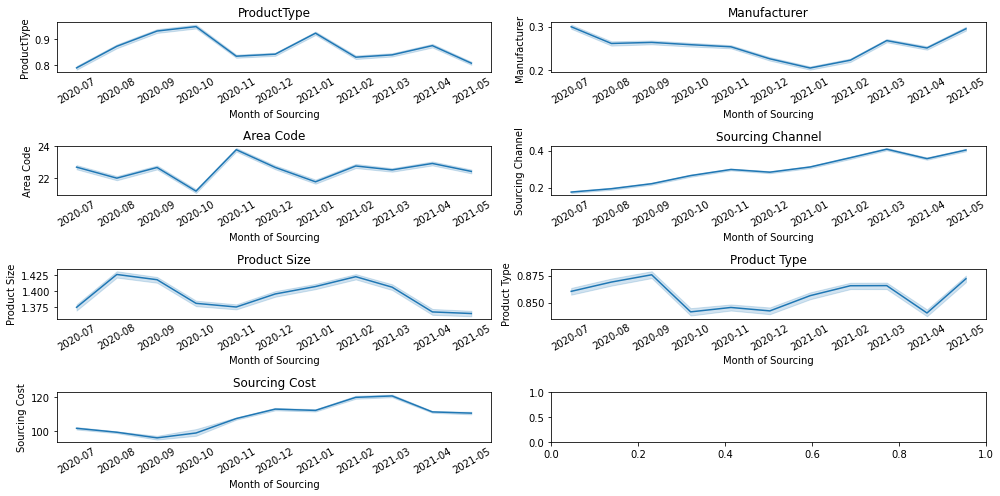

In [ ]:
# Plot line charts
df_plot = data.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [29]:
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
print(len(train), len(test))

440140 110036


In [30]:
cols = [col for col in data.columns if 'Sourcing Cost' not in col]
f_transformer = preprocessing.RobustScaler()
f_transformer = f_transformer.fit(train[cols].to_numpy())
train.loc[:, cols] = f_transformer.transform(
  train[cols].to_numpy()
)
test.loc[:, cols] = f_transformer.transform(
  test[cols].to_numpy()
)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [31]:
cost_transformer = preprocessing.RobustScaler()
cnt_transformer = cost_transformer.fit(train[['Sourcing Cost']])
train['Sourcing Cost'] = cnt_transformer.transform(train[['Sourcing Cost']])
test['Sourcing Cost'] = cnt_transformer.transform(test[['Sourcing Cost']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [56]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        # print(i, time_steps)
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [117]:
range(len(test_data))

range(0, 96)

In [18]:
time_steps = 100
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train['Sourcing Cost'], time_steps)
X_test, y_test = create_dataset(test, test['Sourcing Cost'], time_steps)
print(X_train.shape, y_train.shape)

(440040, 100, 7) (440040,)


In [21]:
data

,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Sourcing Cost
Month of Sourcing,,,,,,,
2021-05-01,2,0,19,3,1,1,10.16
2021-05-01,2,0,16,0,2,1,64.46
2021-05-01,1,0,2,0,1,0,151.70
2021-05-01,0,0,44,0,1,1,146.98
2021-05-01,2,0,16,0,2,1,73.15
...,...,...,...,...,...,...,...
2020-07-01,0,1,36,0,2,1,157.09
2020-07-01,0,1,37,0,1,0,0.00
2020-07-01,0,0,21,0,2,1,136.92


## **Model training**

In [22]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = X_train.shape[1] * X_train.shape[2]
print(n_neurons, X_train.shape[1])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dropout(rate=0.2))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

49 7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 49)           11172     
_________________________________________________________________
lstm_1 (LSTM)                (None, 49)                19404     
_________________________________________________________________
dropout (Dropout)            (None, 49)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 250       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 30,832
Trainable params: 30,832
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Training the model
# we can try better epochs and batch_size using keras tunner.
epochs = 10
batch_size = 3000
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, y_test)
                   )

Epoch 1/10
147/147 [==============================] - 440s 3s/step - loss: 1.6992 - val_loss: 0.8384
Epoch 2/10
147/147 [==============================] - 434s 3s/step - loss: 1.6976 - val_loss: 0.8325
Epoch 3/10
147/147 [==============================] - 432s 3s/step - loss: 1.6972 - val_loss: 0.8307
Epoch 4/10
147/147 [==============================] - 432s 3s/step - loss: 1.6972 - val_loss: 0.8301
Epoch 5/10
147/147 [==============================] - 431s 3s/step - loss: 1.6972 - val_loss: 0.8298
Epoch 6/10
147/147 [==============================] - 434s 3s/step - loss: 1.6972 - val_loss: 0.8297
Epoch 7/10
147/147 [==============================] - 431s 3s/step - loss: 1.6972 - val_loss: 0.8298
Epoch 8/10
147/147 [==============================] - 431s 3s/step - loss: 1.6971 - val_loss: 0.8300
Epoch 9/10
147/147 [==============================] - 432s 3s/step - loss: 1.6971 - val_loss: 0.8297
Epoch 10/10
147/147 [==============================] - 433s 3s/step - loss: 1.6967 - val_lo

In [2]:
model.save('/content/drive/MyDrive/temp/time_series_model.h5')

NameError: ignored

In [5]:
test_data = pd.read_csv('/content/drive/MyDrive/temp/test.csv')

In [7]:
#pre-processing the data.
le = preprocessing.LabelEncoder()
test_data['ProductType']  = le.fit_transform(test_data['ProductType'])
test_data['Manufacturer']  = le.fit_transform(test_data['Manufacturer'])
test_data['Area Code']  = le.fit_transform(test_data['Area Code'])
test_data['Sourcing Channel']  = le.fit_transform(test_data['Sourcing Channel'])
test_data['Product Size']  = le.fit_transform(test_data['Product Size'])
test_data['Product Type']  = le.fit_transform(test_data['Product Type'])
test_data['Month of Sourcing'] = pd.to_datetime([f'20{y}-{m}-01' for y, m in zip(test_data['Month of Sourcing'].str.split('-').str[1], test_data['Month of Sourcing'].str.split('-').str[0])])
test_data = test_data.set_index('Month of Sourcing')

In [9]:
cols = [col for col in test_data.columns if 'Sourcing Cost' not in col]
f_transformer = preprocessing.RobustScaler()
f_transformer = f_transformer.fit(test_data[cols].to_numpy())
test_data.loc[:, cols] = f_transformer.transform(
  test_data[cols].to_numpy()
)

In [10]:
test_data.shape

(96, 7)

In [57]:
X_test_data, y_test_data = create_dataset(test_data, test_data['Sourcing Cost'],)

In [49]:
X_test_data.shape

(95, 2, 7)

In [58]:
model = load_model('/content/drive/MyDrive/temp/time_series_model.h5')

In [59]:
forecast = model.predict(X_test_data) #forecast 
print(forecast.shape)
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, X_test_data.shape[1], axis=-1)
# forecast_copies = forecast_copies.reshape(X_test_data.shape[1])
# print(forecast_copies)
y_pred_future = cost_transformer.inverse_transform(forecast_copies)

(95, 1)


In [ ]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Evaluate Model Performance

In [75]:
y_test_data = test_data['Sourcing Cost'].iloc[0:y_pred_future.shape[0]]
y_test_data.shape
y_pred_future = y_pred_future.reshape(y_pred_future.shape[0])

In [76]:

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_data, y_pred_future)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_data, y_pred_future)/ y_test_data))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_data, y_pred_future)/ y_test_data)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 44.49
Mean Absolute Percentage Error (MAPE): 111.79 %
Median Absolute Percentage Error (MDAPE): 28.57 %


### As I have tried both machine learning and deep learning models. we can try to hypermatter for deep learning model to increase the accuracy. For now  machine learning algorithm given best accuracy so selecting machine learning algorithm.